In [68]:
import numpy as np
import matplotlib.pyplot as plt
import re
%matplotlib inline
num_cpu = 8
clientCPU = [0,1,2,3]
idle_times={}
for i in range(num_cpu):
    idle_times[i]=[]
    
outputfolder = "output_plot_6_aug"
utilFile = outputfolder+"/util.txt"
operationsFile = outputfolder+"/operations.txt"
benchmarkFile = outputfolder+"/benchmark.txt"
with open(utilFile) as f:
    utilBigList = f.read().split("@")[1:]


for utilSingle in utilBigList:
    idle_times_temp = {}
    for i in range(num_cpu):
        idle_times_temp[i]=[]
    stringNewLine = utilSingle.split('\n')[2:]
    for stringLine in stringNewLine:        
        words = stringLine.split()
        if(len(words)>=2 and words[2].isdigit()):
            if(words[0] is "Average:"):
                print("Average")
                continue
            CPU = int(words[2])
            idle = float(words[-1].rstrip('\x00'))
#             print(CPU)
#             print(idle)
            idle_times_temp[CPU].append(idle)
    for i in range(num_cpu):
        idle_times[i].append(idle_times_temp[i])
idle_times_avg = {}
for i in range(num_cpu):
    idle_times_avg[i]=[]
    for times in idle_times[i]:
        idle_times_avg[i].append(np.mean(times))
#print(idle_times_avg)

with open(operationsFile) as f:                                                                                                                                                                                     
    operationsStr = f.read().split('\n')[:-1]
operations = np.array(map(int, operationsStr))

def readBenchmark(benchmarkFile):
    readLatency95 = []
    updateLatency95 = []
    readLatency99 = []
    updateLatency99 = []
    readOperations = []
    updateOperations = []
    throughput = []
    with open(benchmarkFile) as f:
        lines = f.readlines()
        for line in lines:
    #         print(line)
            if re.search('\[READ\]\, 95thPercentileLatency\(us\)', line, re.I):
                readLatency95.append(float(line.split()[2]))
            if re.search('\[UPDATE\]\, 95thPercentileLatency\(us\)', line, re.I):
                updateLatency95.append(float(line.split()[2]))
            if re.search('\[READ\]\, 99thPercentileLatency\(us\)', line, re.I):
                readLatency99.append(float(line.split()[2]))
            if re.search('\[UPDATE\]\, 99thPercentileLatency\(us\)', line, re.I):
                updateLatency99.append(float(line.split()[2]))
            if re.search('\[READ\], Operations',line, re.I):
                readOperations.append(float(line.split()[2]))
            if re.search('\[UPDATE\], Operations',line, re.I):
                updateOperations.append(float(line.split()[2]))
            if re.search('\[OVERALL\], Throughput',line, re.I):
                throughput.append(float(line.split()[2]))
    readLatency99 = np.array(readLatency99)
    updateLatency99 = np.array(updateLatency99)
    throughput = np.array(throughput)
    return {
        "readLatency95":readLatency95,
        "updateLatency95":updateLatency95,
        "readLatency99":readLatency99,
        "updateLatency99":updateLatency99,
        "readOperations":readOperations,
        "updateOperations":updateOperations,
        "throughput":throughput
           
    }



for cpu in idle_times_avg:
    idle_times_avg[cpu] = np.array(idle_times_avg[cpu])
# idle_times_avg = np.array(idle_times_avg)?
# print(idle_times_avg[0])
   




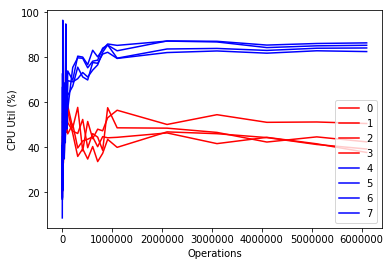

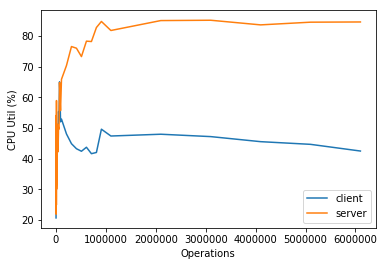

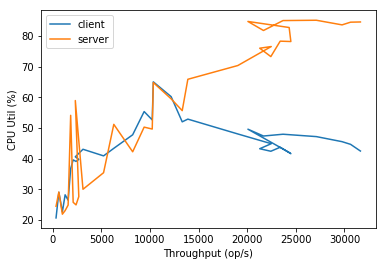

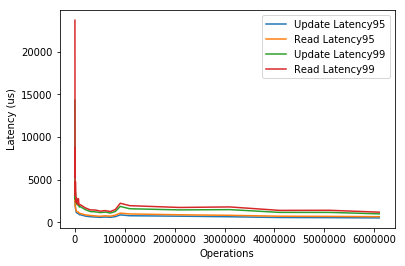

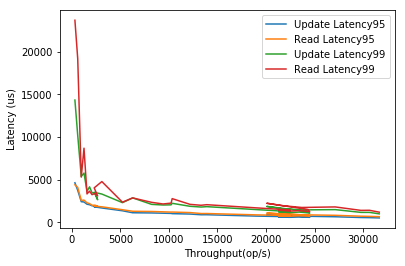

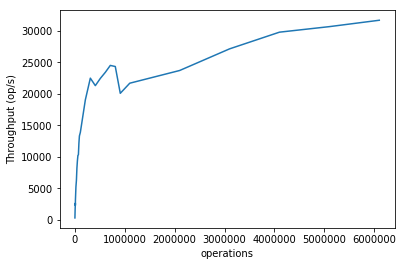

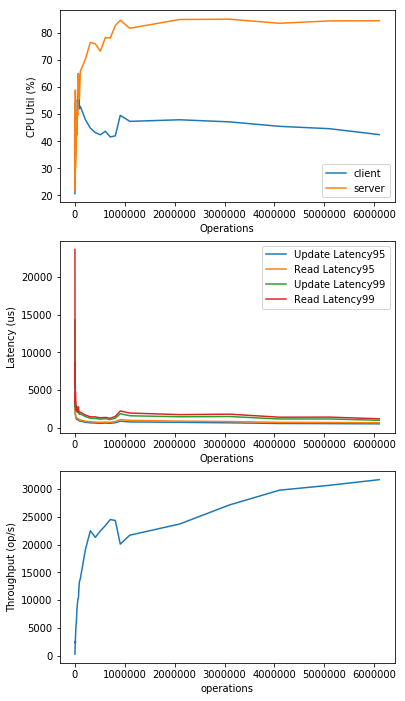

In [73]:
bench1 = readBenchmark(benchmarkFile)
#bench1 = readBenchmark("output/benchmark2.txt")
for i in idle_times_avg:
    idle_times_avg[i]=idle_times_avg[i][0:len(bench1["throughput"])]
operations = operations[:len(bench1["throughput"])]
util_bench = idle_times_avg[0]*0
util_server = idle_times_avg[0]*0
for i in range(num_cpu):
    if i in clientCPU:
        util_bench = util_bench + idle_times_avg[i]
    else:
        util_server = util_server + idle_times_avg[i]
util_bench = 100.0 - util_bench/len(clientCPU)
util_server = 100.0 - util_server/(num_cpu-len(clientCPU))
# readLatency = bench1["readLatency"]
plt.figure(1)

for i in range(num_cpu):
    if(i in clientCPU):
        plt.plot(operations,100-np.array(idle_times_avg[i]),label=i,color='red')
        continue
    plt.plot(operations,100-np.array(idle_times_avg[i]),label=i,color='blue')
plt.legend()
plt.xlabel("Operations")
plt.ylabel("CPU Util (%)")
plt.show()

plt.figure(2)
plt.plot(operations,util_bench,label="client")
plt.plot(operations,util_server,label="server")
plt.legend()
plt.xlabel("Operations")
plt.ylabel("CPU Util (%)")
plt.savefig("util.png")
plt.show()

plt.figure(2)
plt.plot(bench1["throughput"],util_bench,label="client")
plt.plot(bench1["throughput"],util_server,label="server")
plt.legend()
plt.xlabel("Throughput (op/s)")
plt.ylabel("CPU Util (%)")
plt.show()

plt.figure(3)
plt.plot(operations[0:len(bench1["updateLatency95"])],bench1["updateLatency95"],label="Update Latency95")
plt.plot(operations[0:len(bench1["updateLatency95"])],bench1["readLatency95"],label="Read Latency95")
plt.plot(operations[0:len(bench1["updateLatency99"])],bench1["updateLatency99"],label="Update Latency99")
plt.plot(operations[0:len(bench1["updateLatency99"])],bench1["readLatency99"],label="Read Latency99")
# plt.ylim(ymax=10000)
plt.legend()
plt.xlabel("Operations")
plt.ylabel("Latency (us)")
plt.savefig("latency.png")
plt.show()


plt.figure(3)
plt.plot(bench1["throughput"],bench1["updateLatency95"],label="Update Latency95")
plt.plot(bench1["throughput"],bench1["readLatency95"],label="Read Latency95")
plt.plot(bench1["throughput"],bench1["updateLatency99"],label="Update Latency99")
plt.plot(bench1["throughput"],bench1["readLatency99"],label="Read Latency99")
# plt.ylim(ymax=10000)
plt.legend()
plt.xlabel("Throughput(op/s)")
plt.ylabel("Latency (us)")
plt.savefig("throughput.png")
plt.show()

plt.figure()
plt.plot(operations[0:len(bench1["throughput"])],bench1["throughput"])
plt.xlabel("operations")
plt.ylabel("Throughput (op/s)")
# plt.savefig("throughput.png")
plt.show()

# plt.figure(4)
# plt.plot(bench1["throughput"],bench1["updateLatency95"],label="Update Latency95")
# plt.plot(bench1["throughput"],bench1["readLatency95"],label="Read Latency95")
# plt.plot(bench1["throughput"],bench1["updateLatency99"],label="Update Latency99")
# plt.plot(bench1["throughput"],bench1["readLatency99"],label="Read Latency99")

# plt.legend()
# plt.show()


# plt.figure(4)
# plt.plot(operations[:len(readOperations)],np.array(operations[:len(readOperations)])-(np.array(readOperations)+np.array(updateOperations)))
# plt.show()
fig = plt.figure()
(a,b) = fig.get_size_inches()
plt.figure(figsize=(a, b*3))
plt.subplot(3,1,1)
plt.plot(operations,util_bench,label="client")
plt.plot(operations,util_server,label="server")
plt.legend()
plt.xlabel("Operations")
plt.ylabel("CPU Util (%)")
plt.savefig("util.png")
# plt.show()


plt.subplot(3,1,2)
plt.plot(operations[0:len(bench1["updateLatency95"])],bench1["updateLatency95"],label="Update Latency95")
plt.plot(operations[0:len(bench1["updateLatency95"])],bench1["readLatency95"],label="Read Latency95")
plt.plot(operations[0:len(bench1["updateLatency99"])],bench1["updateLatency99"],label="Update Latency99")
plt.plot(operations[0:len(bench1["updateLatency99"])],bench1["readLatency99"],label="Read Latency99")
# plt.ylim(ymax=10000)
plt.legend()
plt.xlabel("Operations")
plt.ylabel("Latency (us)")
# plt.savefig("latency.png")
# plt.show()

plt.subplot(3,1,3)
plt.plot(operations[0:len(bench1["throughput"])],bench1["throughput"])
plt.xlabel("operations")
plt.ylabel("Throughput (op/s)")
plt.savefig("graphs.png")
plt.show()

In [57]:
bench1["readLatency99"]

array([ 23663.,  19167.,   5303.,   8687.,   3335.,   3657.,   3249.,
         3391.,   3093.,   4043.,   4779.,   2365.,   2867.,   2351.,
         2157.,   2257.,   2783.,   2113.,   2004.,   2073.,   1698.,
         1460.,   1448.,   1321.,   1380.,   1272.,   1506.,   2241.,
         1958.,   1748.,   1811.,   1407.,   1418.,   1198.])